### gpu inference with Efficientnet_v2

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as prf

- PIL: modul per fer tractament de imatges
- Quan importes torch, ja hi ha PIL

In [3]:
from PIL import Image, ExifTags, ImageOps, ImageDraw
from src import bbox2tlbr, sqrbbox, compute_IoU

### data

In [4]:
df = pd.read_csv('../mosquits/phase2_test.csv')
len(df)

2763

In [5]:
df.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,test_00000.jpeg,4032,1908,711.0,378.0,1721.0,1367.0,culex
1,test_00001.jpeg,1997,1831,853.0,412.0,1364.0,1085.0,culex
2,test_00002.jpeg,4160,3120,20.0,145.0,3049.0,4160.0,japonicus-koreicus
3,test_00003.jpeg,4000,3000,68.0,54.0,3695.0,2376.0,japonicus-koreicus
4,test_00004.jpeg,1600,1200,719.0,400.0,1045.0,745.0,culex


In [6]:
df.class_label.value_counts()

class_label
albopictus            1202
culex                 1127
japonicus-koreicus     232
culiseta               159
anopheles               33
aegypti                 10
Name: count, dtype: int64

### model

- inicialitzar el device

In [7]:
import torch
from torchvision import transforms
# Agafa la gpu si està disponible sino cpu
_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_device

device(type='cuda', index=0)

In [8]:
# Agafar el model i carregar-lo a la gpu
model = torch.load('../mosquits/cnn_mosquits/stage1/classifier.pth').to(_device).eval()

### inference

In [9]:
# on tenim les imatges
_imgRoot = '../mosquits/phase2_test/test/final'

# Set de classes
_classes = ['aegypti', 'albopictus', 'anopheles', 'culex', 'culiseta', 'japonicus-koreicus', '??']

# Mida amb el qual farà inferència (tamany amb el que el model ha sigut ensenyat)
_imgSize = 512

# Mitjana i variança de tots els canals (RGB)
_imgNorm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#_imgNorm = ([0.61800831, 0.57129184, 0.52785762], [0.07639834, 0.08574163, 0.09442848])

- totes les imatge són diferents
- el model s'ha entrenat amb un format concret
- hem de passar les imatges a una mica concreta.
- parametre de normalització. les imatges es norm, vol dir que tenim tot el lot i calculem la mitjana i la variança per cada un dels canals (RGB)

- provem de treure el control image max-size

In [10]:
# control image max-size 
# Image.MAX_IMAGE_PIXELS = 201326592
# Image.warnings.simplefilter('error', Image.DecompressionBombWarning)

In [11]:
transform = transforms.Compose([
    transforms.Resize((_imgSize, _imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(_imgNorm[0], _imgNorm[1])
])

- torch vision especific per imatge, 
- modul transform. incorpora funcions, metodes, per fer transformacions que volem fer per entrenar les imatges. 
- el transform més ovi i necessari. resize, perque pot tenir el tamany que sigui
- transform es com un pipeline (anar encadenant regresion....)
- fem varis tipus de transforms. resize, to tensor, normalize. 
- 1. donar el tamany que necessitem per passar-li al model.
- 2. Aquesta imatge es una img que hem obert amb el PIL image, aquesta imatge resideix a la memòria de la cpu, l'hem de passar a la gpu (que esta pensada per anar amb tensors).
- la gpu esta especialitzada en fer algebra de tensors. 
- hem de pasar la img a la gpu, (la pill image tenim valors sensers de 255), en el tensor, aquests valors van de 0-1 (float)
- quan fem un to tensor normalitzar de 0,1 i passar-ho a la gpu
- convertim una instancia de PIL a de tensors
- 3. Normalize, aplica la mitjana de cada una dels canals i la variança, ho estandaritza aquests valors.
- ---
- Si normalitzes amb els valors del teu dataset, (els colors s'han modificat), diferent de com s'ha fet servir per entrenar el model. 
- si treballes amb un model pre entrenat es millor normalitzar amb els valors que es van fer servir per entrenar el model. 
- si entranem final pooling, si que ho podem fer amb els nostres. 

#### inference
- Agafem una imatge i la obrim

In [12]:
# pick one image
row = df.sample(1).iloc[0]
row

img_fName      test_00908.jpeg
img_w                      768
img_h                     1024
bbx_xtl                  335.0
bbx_ytl                  264.0
bbx_xbr                  499.0
bbx_ybr                  450.0
class_label              culex
Name: 908, dtype: object

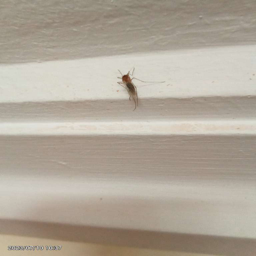

In [13]:
# open image file
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
pilImg.resize((256, 256))

- Amb el square bounding box, el model espera un quadrat. 
- la funció agafa el costat més llarg i la fa quadrada (mirar la funció). 
- si va fora, pillaría una banda negra. o pot ser que haguem fet un canuto

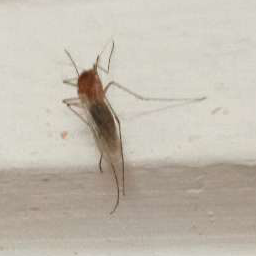

In [14]:
# crop image
bbox = sqrbbox([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], pilImg.size)
pilImg = pilImg.crop(bbox)
pilImg.resize((256, 256))

In [15]:
# transform to torch tensor image
torchImg = torch.unsqueeze(transform(pilImg), dim = 0).to(_device)
torchImg

tensor([[[[1.2557, 1.2557, 1.2385,  ..., 1.5468, 1.5297, 1.5125],
          [1.2728, 1.2728, 1.2557,  ..., 1.5468, 1.5297, 1.5125],
          [1.2899, 1.2899, 1.2728,  ..., 1.5468, 1.5297, 1.5297],
          ...,
          [1.3413, 1.3413, 1.3413,  ..., 1.4783, 1.4612, 1.4440],
          [1.3584, 1.3584, 1.3584,  ..., 1.4954, 1.4783, 1.4612],
          [1.3584, 1.3584, 1.3584,  ..., 1.5125, 1.4954, 1.4783]],

         [[1.3081, 1.3081, 1.2906,  ..., 1.6583, 1.6408, 1.6232],
          [1.3256, 1.3256, 1.3081,  ..., 1.6583, 1.6408, 1.6232],
          [1.3431, 1.3431, 1.3256,  ..., 1.6583, 1.6408, 1.6408],
          ...,
          [1.4482, 1.4482, 1.4482,  ..., 1.5357, 1.5182, 1.5007],
          [1.4657, 1.4657, 1.4657,  ..., 1.5532, 1.5357, 1.5182],
          [1.4657, 1.4657, 1.4657,  ..., 1.5707, 1.5532, 1.5357]],

         [[1.3154, 1.3154, 1.2980,  ..., 1.7163, 1.6988, 1.6814],
          [1.3328, 1.3328, 1.3154,  ..., 1.7163, 1.6988, 1.6814],
          [1.3502, 1.3502, 1.3328,  ..., 1

- Li fem un unsqueeze que es perque els models esperen tot un batch de imatges, no esperen les imatges de una en una perquè es ineficient. El que espera es que preparem unes quantes imatges (8,10) tantes com ens permeti la memoria de la gpu i tantes com ens permeti el tamany de les imatges, si les ratallem a 512x512 (ocuparà més) que 128x128 però perdem qualitat. 
- Batch, per la propagació de l'error. De l'ordre de 30/60/80. Més memòria i més petites les imatges, més gran pots fer el batch. 
- Les gpu ja estàn pensadas per rebre una pila de imatges. Cada imatge té:
    - numero de canals (RGB)
    - amplada
    - alçada 
- unsqueeze, si només una imatge, ens posa aquest nou eix (1,3,256,256). Imatge matriu amb tres dimensions i les apilem (posem un nou eix). 
- La forma d'apilar aquestes imatges es una 4a dimensió.
- Quan volem empaquetar coses amb un batch, totes han de tenir la mateixa mida.
- ---
- un cop passar de array de numpy a tensor de torch
- ho enviem a la gpu
- ---
- com que estaritzem amb la mitjana i variança de cada canal són valors que han d'estar entre 0 i 1. Image Normalization.
    - s'aconsegueix que un canal de color no predomini sobre els altres. 
    - quan fas una estandaritzador, fas la variança de cada canal = 1, si tenies blaus en rang molt alt i vermells en rang molt baix, tu els hi dones la mateixa mida. Tots tenen la mateixa importància. 

In [16]:
# inference

# Model et paso aquesta imatge i ell fa la predicció
output = model(torchImg)

In [17]:
# logits
output

tensor([[-0.7976, -0.6026, -0.8836,  3.3028, -0.8287, -0.8270, -0.7005]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

- a la ultima capa tenim una neurona per cada classe, ens torna com d'activada està cada classe.
- logits (nivell d'activació de cada neurona en la capa de sortida). 
- tensor amb 7 valors. un per cada classe. 
- molts negatius i un molt positiu
- això són nivells d'activació, no té perquè donar 1
- ---
- el que surt del model es un tensor i l'hem de portar cap a la cpu

In [18]:
# logits are activations, NOT probabilities (can be negative, do not add up to one) !!!
torch.sum(output)

tensor(-1.3372, device='cuda:0', grad_fn=<SumBackward0>)

In [19]:
# convert logits to class probabilities
scores = torch.nn.functional.softmax(output, dim = 1)

# Ara la suma si que dona 1
scores, torch.sum(scores)

(tensor([[0.0150, 0.0183, 0.0138, 0.9072, 0.0146, 0.0146, 0.0166]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>))

- La funció softmax()
- relacionada amb el logistic regression.
    - convertia una valor a la recta real -inf a +inf. els convertia a -1 i +1. Imagina la sigmoid function
- la funció softmax() a cada x hi posa els logits (outputs).
- converteix els valors a 0 i 1
- després els suma tots i divideix per la suma (normalitza i converteix en probabilitats)
- Més que probabilitats sinó scores
- ---
- scores es un tensor que està a la gpu encara
- el tensor el podem portar a la cpu amb el metode cpu

# En veritat el que fa soft max, que l'altre dia es va equivocar

- es pasa per la sigmoid function entre 0 i 1, agafar tots sumar i dona probabilitats. 
- el que fa en veritat (pot ser que sigui diferent o no): 
- $y=\frac{e^{x}}{\sum{e^{x}}}$

### funcio soft max

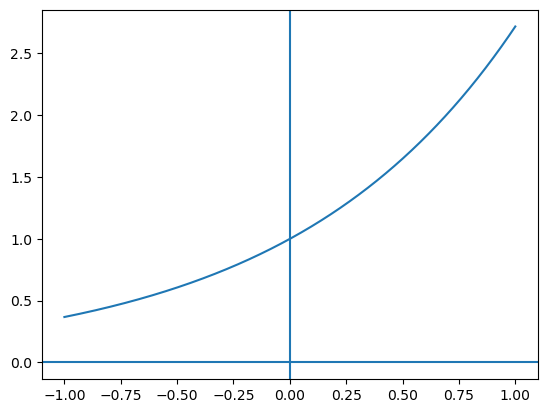

In [5]:
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.exp(x))
plt.axhline(y=0)
plt.axvline(x=0)

- com més activació més puja
- sumem tots els valors i dividim per la suma i queden normalitzats
- probabilitats o el que en diem scores
- ---
- Si pensem amb termes de scores i no de activacions. 
- Tenim 3 classes: 0.35 / 0.32 / 0.33 (scores han de sumar 1, perquè el soft max normalitza)
- Ja tenim la classe 1 guanyadora.
- No es lo mateix que 0.97 / 0.02 / 0.02
- ens ho creiem més. 
- Quan fem la confusion matrix, estem contant igual de bons els dos. 
- Fixem un thr, un llindar de confianza a partir el qual ens creurem la classificació que doni el model.
- thr = 0, tenim el cas de la classe guanyadora. 
- thr = 0.5, no ens creiem la primera. perquè és 0.35
- aqui entra la roc curve.
- quin es el llinar que ens faría tenir una metrica millor amb un nivell de confiança que ens el podem creure. 
- ---
- la gracia de convertir els logits a scores amb la funció soft max és: 
    - llindar, scores i tal, que venen dels nivells d'activació.
    - la gracia es que si hi ha una neurona molt activada, si hi ha molta diferencia d'activació entre les neurones.
    - a l'eix x de la graficad e baix. 
    - el nivell d'activació de més a la dreta és més alt 4, va a 80 i els petis practicament 0. -> 60 +0++0+2...
    - 60/62 = 1, els altres 0
    - els scores tenim 1 i 0 per els altres
    - si en tenim un a 3, tindrà una proporció sobre el total
    - serà 1,7 / 0,2 i la resta
    - la gracia d'això està en que: 
        - totes les neurones etan sobre el mateix nivel (juntes) mateix ordre (tots aprop del 3). això vol dir que tindrem una distribució de probabilitats uniforme.
        - si es dona el cas, de que tenim molt poca activació de les neurones, totes desactivades o molt poc. sería un cas de tots a la esquerre i una molt poc també. 
        - la proporcio de la guanyadora serà 0.1/0.11 -> n'hi ha una de molt poc guanyadora
        - es converteixen iguals
        - convertim uns nivells d'activació en unes proporcions que el que tenen en compte com de positives son i com de juntes o separades estan. 
        - si n'hi ha tres semblants però a la dreta tenim dubtes
        - si n'hi ha un de molt poc i els altres dos a 0 també tenim dubtes
        - els dos donarien 0.33 / 0.33 / 0.33 , per tant no ens podem creure cap dels casos. 
        

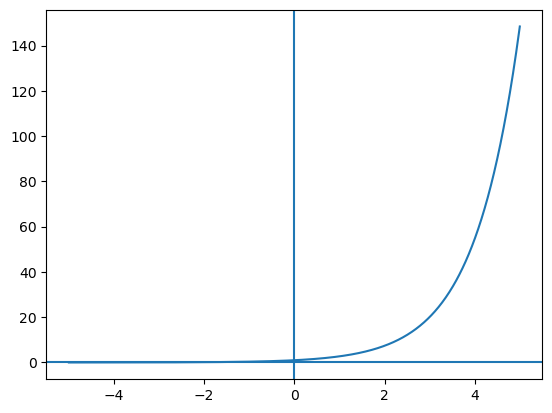

In [6]:
x = np.linspace(-5, 5, 1000)
plt.plot(x, np.exp(x))
plt.axhline(y=0)
plt.axvline(x=0)

In [20]:
# scores is a gpu tensor, must be transferred to the cpu and converted to numpy
class_probs = scores.cpu().detach().numpy()[0]
class_probs

array([0.01502851, 0.01826334, 0.01378977, 0.90719754, 0.01456834,
       0.01459246, 0.01656001], dtype=float32)

- detach(), metode dels tensors, un tensor no només es els tensors sinoque també te atributs (gradients, metodes, etc). 
- la classe esta pensada per fer operacions molt potents. 
- el detach s'ho carega tot.
- ---
- numpy té aquesta dimensió extra que s'ha d'eliminar per això posem el (0)

In [21]:
# (hard) class label
print('+++ ground truth: %s' %row.class_label) 
print(' predicted class: %s' %_classes[np.argmax(class_probs)])

+++ ground truth: culex
 predicted class: culex


- Si vols un hard classification pots pillar els valors dels logits.
- Soft classification s'ha de fer amb el softmax() per: roc curve, etc.  

#### Fer inferencia amb un lot

#### batch prediction

In [22]:
def predict(row):
    
    # open image file
    pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
    
    # crop image
    bbox = sqrbbox([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], pilImg.size)
    pilImg = pilImg.crop(bbox)
    
    # transform to torch tensor image
    torchImg = torch.unsqueeze(transform(pilImg), dim = 0).to(_device)
    
    # inference
    output = model(torchImg)
    
    # scores
    output = torch.nn.functional.softmax(output, dim = 1)
    scores = output.cpu().detach().numpy()[0]
    
    # get class predictions
    pred = {k:s for k, s in zip(_classes, scores)}
    pred['img_fName'] = row.img_fName
    pred['pred_label'] = _classes[np.argmax(scores)]
    
    return pred

In [23]:
%%time
outputs = df.apply(predict, axis = 1)

/home/jaume/miniconda3/envs/entorn/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


CPU times: user 37min 14s, sys: 17.1 s, total: 37min 31s
Wall time: 3min 46s


In [31]:
df.head()

,img_fName,img_w,img_h,bbx_xtl,bbx_ytl,bbx_xbr,bbx_ybr,class_label
0,test_00000.jpeg,4032,1908,711.0,378.0,1721.0,1367.0,culex
1,test_00001.jpeg,1997,1831,853.0,412.0,1364.0,1085.0,culex
2,test_00002.jpeg,4160,3120,20.0,145.0,3049.0,4160.0,japonicus-koreicus
3,test_00003.jpeg,4000,3000,68.0,54.0,3695.0,2376.0,japonicus-koreicus
4,test_00004.jpeg,1600,1200,719.0,400.0,1045.0,745.0,culex


- La gpu no pot estar arribar a treballar al 100%.
    - Va imatge per imatge. Va a temps de lectura de disc, una de les coses més costoses, moure punter, llegir, etc.
    - la cpu fa la transferencia (tarda)
    - la cpu va lenta i la gpu va follada, per això la gpu no va al 100%, per això treballem amb batch, loaders
    - això optimitza aquesta transferencia. 
    - amb paral·lelalització, aprofitar el temps que tarda la gpu (procesar 1 batch), la cpu ja té l'altre, ja ho veurem.
- ---
- Dels primers hackejos dels servidors, posavem una imatge comprimida, que era una compresio recurrent que s'anava descomprimint fins a l'infinit fins que feia saltar la memoria del servidor.
- Forma de hackejar superada, el pill posa aquest warning
- descomprimeix una imatge gran, que si se sobre passa, talla la descompressio i envia el warning.
- La tecnologia dels mobils ha deixa petit el parametre del pill
- l'ha descomprimit fins a un punt i ja està
- ---
- estem parlant de que quan es comprimeix una imatge, transformada de forier, totes les frequencies iguals i es codifiquen d'una determinada manera que al final hi ha un fitxer que ocupa menys. 
- loss compression lossy compression
- jpg fa loss, comprimeix al 75% per defecte

In [24]:
df_ = pd.merge(df, pd.DataFrame([output for output in outputs]), how = 'inner', on = 'img_fName')

In [25]:
df_.groupby('class_label').pred_label.value_counts()

class_label         pred_label        
aegypti             aegypti                  7
                    albopictus               1
                    culex                    1
                    culiseta                 1
albopictus          albopictus            1169
                    ??                      12
                    japonicus-koreicus       8
                    culex                    6
                    aegypti                  5
                    culiseta                 2
anopheles           anopheles               27
                    culex                    3
                    culiseta                 3
culex               culex                 1102
                    culiseta                10
                    ??                       9
                    anopheles                4
                    aegypti                  1
                    albopictus               1
culiseta            culiseta               141
                    c

- Classes predides i classes reals, ja podem aplicar els metodes que ja coneixem

#### Classification

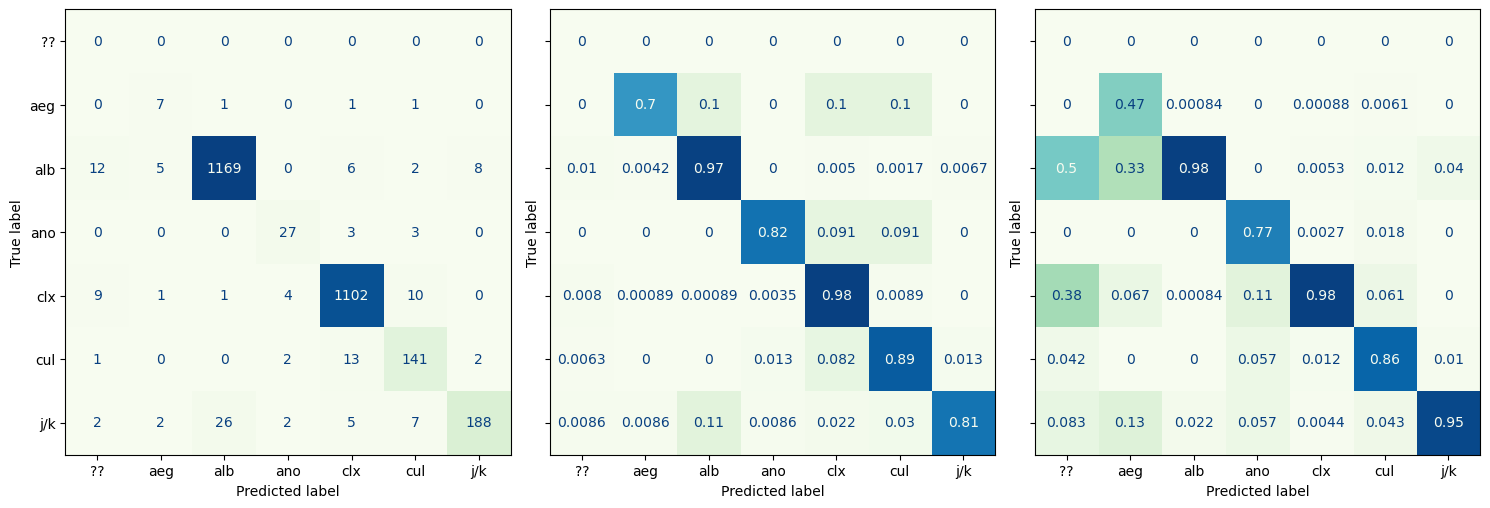

In [26]:
_, axs = plt.subplots(1, 3, figsize = (15, 7), sharey = True)
for i, norm in enumerate([None, 'true', 'pred']):
    ConfusionMatrixDisplay.from_predictions(
        df_.class_label,
        df_.pred_label,
        normalize = norm,
        ax = axs[i],
        # Sempre hauría d'haber un que guanyes, però ??
        display_labels = ['??', 'aeg', 'alb', 'ano', 'clx', 'cul', 'j/k'],
        cmap = 'GnBu',
        colorbar = None
    )
plt.tight_layout()

In [27]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prf(df_.class_label, df_.pred_label, average = mode, zero_division = 0)[:3] for mode in avrgs], columns = ['precision', 'recall', 'f-score'], index = avrgs)

,precision,recall,f-score
macro,0.714168,0.737955,0.721813
micro,0.953312,0.953312,0.953312
weighted,0.962745,0.953312,0.957459


#### check predictions

In [28]:
i = -1

+++  0 test_00000.jpeg - culex / culex


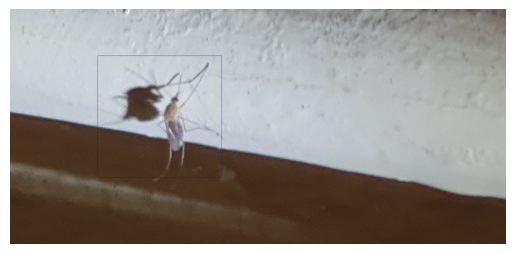

In [29]:
i += 1
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 2)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d %s - %s / %s' %(i, row.img_fName, row.class_label, row.pred_label))

- image draw, submodul de pill, ens permet dibuixar sobre una imatge

+++185 - albopictus / ??


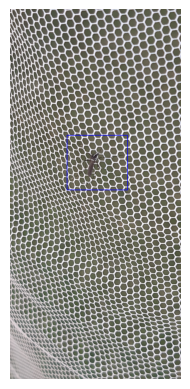

In [30]:
i = 185#, 202, 343
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 8)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d - %s / %s' %(i, row.class_label, row.pred_label))